# BCI IV competititon data

Data was downloaded from [here](https://www.bbci.de/competition/iv/#dataset2a).

## Import libraries

In [1]:

#%% Import libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from IPython.display import clear_output

## Import and organize data

Select the data to be imported with the `import_all` boolean.
- True: Import all files in the folder
- False: Import a single file


In [2]:
#%% Select wether to import all files or one
import_all = False

data_folder = os.getcwd() + "\\Data\\BCI IV competition"  # Data folder
# channel_idx = np.arange(22)
channel_idx = slice(22)

#%% Import all trials 
if import_all:  
    files = os.listdir(data_folder)

    # Implementation missing

#%% Import a single file
else:           
    files = ['\\A01E.gdf']
    gdf_data = mne.io.read_raw_gdf(data_folder+files[0], verbose=False)

    #%% Organize variables
    eeg_raw = gdf_data.get_data(picks=channel_idx)          # Raw EEG data [V]
    srate = gdf_data.info['sfreq']                          # Sampling rate [Hz]
    ch_names = gdf_data.info['ch_names'][channel_idx]       # Channel names [str]
    n_samples = gdf_data.n_times                            # Number of samples [n]
    n_chans = np.size(eeg_raw,0)                            # Number of channels [n]
    time_vect = np.linspace(0, n_samples/srate, n_samples)  # Time vector [sec]

clear_output()  # Clear Jupyter Notebook output

## Plot raw data

Run this section to visualize the raw data

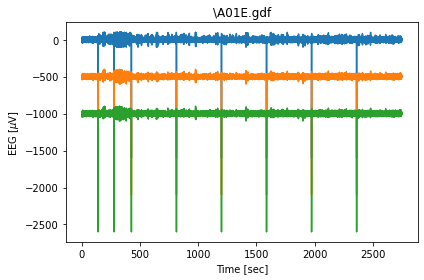

In [3]:
#%% Enable to plot raw data
plot_raw = True
chans_plot = np.arange(3)   # Choose channels to plot

if plot_raw:
    for file in files:
        fig, ax = plt.subplots()
        for chan in chans_plot:
            ax.plot(time_vect, eeg_raw[chan,:]*1e6 - chan*500)
            ax.set_ylabel("EEG [$\mu$V]")
            ax.set_xlabel("Time [sec]")
            ax.set_title(file)
        plt.tight_layout()

## Clean EEG data

Use the Artifact Removal Tool to clean the data. Each file is trimmed to an integer number of non-overlapping `n_windows` of length `window`.

In [11]:
# eeg_clean = np.zeros_like(eeg_raw)  # Preallocate EEG data, missing to implemment for multiple channels

window = 3  # Window length [sec]
n_windows = 85
n_trim = int(n_windows * srate * window)            # Number of samples to trim [n]
artifact_found = np.zeros((n_chans, n_windows))     # Flag to determine if artifacts where found
saturation_found = np.zeros((n_chans, n_windows))   # Flag to determine if saturations where found

# Clean and trim each file selected
for file in files:
    time_vect = time_vect[0:n_trim]
    eeg_raw = eeg_raw[:,0:n_trim]
    
    eeg_tensor_raw = np.reshape(eeg_raw, (n_chans, int(window*srate), -1))
    eeg_tensor_clean = np.zeros_like(eeg_tensor_raw)

    for w in range(n_windows):
        [eeg_tensor_clean[:,:,w], artifact_found[:,w], saturation_found[:,w]] = art.remove_eyeblinks_cpu(eeg_tensor_raw[:,:,w], srate, 
                                                                                                        window_length=0.5, n_clusters=10)

    eeg_clean = np.reshape(eeg_tensor_clean, (n_chans,-1))  # Reshape data to its original shape
    
    del eeg_tensor_raw, eeg_tensor_clean    # Delete temporary variables
    

## Plot clean data

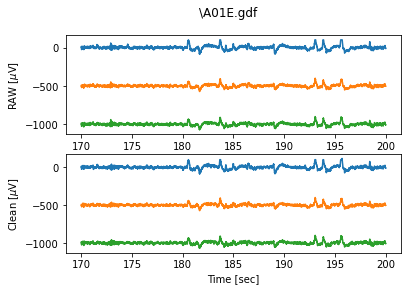

In [12]:
#%% Enable to plot raw data
plot_raw = True
chans_plot = np.arange(3)   # Choose channels to plot 
start = int(srate*170)  # Time to start plot 
                        # int(srate*sec) = sec second to start
                        # 0 = first sample
stop = int(srate*200)   # Time to end plot
                        # int(srate*sec) = sec second to end
                        # -1 = last sample

if plot_raw:
    for file in files:
        fig, ax = plt.subplots(2,1)
        for chan in chans_plot:
            # ax[0].plot(time_vect, eeg_raw[chan,:]*1e6 - chan*500)
            ax[0].plot(time_vect[start:stop], eeg_raw[chan,start:stop]*1e6 - chan*500)
            ax[0].set_ylabel("RAW [$\mu$V]")
            ax[0].set_xlabel("Time [sec]")
            
            # ax[1].plot(time_vect, eeg_clean[chan,:]*1e6 - chan*500)
            ax[1].plot(time_vect[start:stop], eeg_clean[chan,start:stop]*1e6 - chan*500)            
            # ax[1].plot(eeg_clean[chan,start:stop]*1e6 - chan*500)            
            
            ax[1].set_xlabel("Time [sec]")
            ax[1].set_ylabel("Clean [$\mu$V]")

            fig.suptitle(file)
            
        plt.show()

## Artifacts and saturations

Plot the raw and cleaned data, highilighting the regions where there were no artifacts found, or there were saturations found


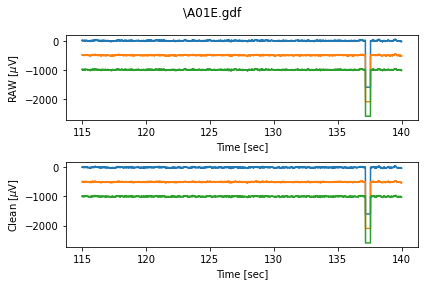

In [6]:
#%% Enable to plot raw data
plot_raw = True
chans_plot = np.arange(3)   # Choose channels to plot
start = int(srate*115)  # Time to start plot 
                        # int(srate*sec) = sec second to start
                        # 0 = first sample
stop = int(srate*140)   # Time to end plot
                        # int(srate*sec) = sec second to end
                        # -1 = last sample

if plot_raw:
    for file in files:
        fig, ax = plt.subplots(2,1)
        for chan in chans_plot:
            # RAW data
            ax[0].plot(time_vect[start:stop], eeg_raw[chan,start:stop]*1e6 - chan*500)
            ax[0].set_ylabel("RAW [$\mu$V]")
            ax[0].set_xlabel("Time [sec]")
            
            # Clean data
            ax[1].plot(time_vect[start:stop], eeg_clean[chan,start:stop]*1e6 - chan*500)            
            ax[1].set_xlabel("Time [sec]")
            ax[1].set_ylabel("Clean [$\mu$V]")

            # Non-artifact regions
            # - Create for non artifact indices
            non_artifact_idx = np.zeros(n_windows)  # Preallocate index array
            non_artifact_eeg = np.zeros(np.size(eeg_clean,1))
            for i in range(1,n_windows):
                artifact_window = artifact_found[chan,i]
                
                non_artifact_idx[i] = int(artifact_found[chan,i]*i*srate)

                if artifact_window:
                    wstart = int(artifact_found[chan,i-1]*i*srate)
                    wend = int(artifact_found[chan,i]*i*srate)
                    non_artifact_eeg[wstart:wend] = 1

                non_artifact_region = collections.BrokenBarHCollection.span_where(time_vect, ymin=-1e6, ymax=1e6,
                                                                            where=non_artifact_eeg, facecolor='red', alpha=0.5)
            ax[1].add_collection(non_artifact_region)

            # Non-artifact regions
            # - Create for non artifact indices
            non_artifact_idx = np.zeros(n_windows)  # Preallocate index array
            non_artifact_eeg = np.zeros(np.size(eeg_clean,1))
            for i in range(1,n_windows):
                artifact_window = artifact_found[chan,i]
                
                non_artifact_idx[i] = int(artifact_found[chan,i]*i*srate)

                if artifact_window:
                    wstart = int(artifact_found[chan,i-1]*i*srate)
                    wend = int(artifact_found[chan,i]*i*srate)
                    non_artifact_eeg[wstart:wend] = 1

                non_artifact_region = collections.BrokenBarHCollection.span_where(time_vect, ymin=-1e6, ymax=1e6,
                                                                            where=non_artifact_eeg, facecolor='red', alpha=0.5)
            ax[1].add_collection(non_artifact_region)

            fig.suptitle(file)
            
        plt.tight_layout()



In [7]:
a = eeg_raw[:,start:stop]
d = eeg_clean[:,start:stop]
[b,af,_] = art.remove_eyeblinks_cpu(a, srate, window_length = 0.3, ssa_threshold=0.03)
f = np.reshape(eeg_tensor_clean[:,:,20:30], (n_chans, -1))

fig, ax = plt.subplots(2,1)
for c in range(2):
    ax[0].plot(np.linspace(0, np.size(a,1)/srate, np.size(a,1)), a[c,:])
    ax[0].set_ylim([-0.25e-3, 0.25e-3])
    ax[1].plot(np.linspace(0, np.size(a,1)/srate, np.size(a,1)), b[c,:])
    ax[1].set_ylim([-0.25e-3, 0.25e-3])

plt.tight_layout()

NameError: name 'eeg_tensor_clean' is not defined